# Import

In [12]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque
import random

import matplotlib.pyplot as plt
from IPython.display import clear_output, display
%matplotlib inline

# Hyperparamètres

In [2]:
EPISODES = 500
GAMMA = 0.99            # Facteur de discount
LEARNING_RATE = 0.001   # Taux d'apprentissage
BATCH_SIZE = 64         # Taille des batchs
MEMORY_SIZE = 10000     # Taille de la mémoire
EPSILON_START = 1.0     # Épsilon initial pour l'exploration
EPSILON_END = 0.01      # Épsilon minimal
EPSILON_DECAY = 0.995   # Décroissance d'épsilon
TARGET_UPDATE = 10      # Fréquence de mise à jour du réseau cible

# Réseau de Neurones

In [ ]:
class DQNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Buffer d'expérience

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def add(self, experience):
        self.memory.append(experience)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Fonction ε-greedy

In [ ]:
def select_action(state, policy_net, epsilon, action_size):
    if np.random.rand() < epsilon:
        return np.random.randint(action_size)
    else:
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            return policy_net(state).argmax(dim=1).item()

# Entraînement du réseau

In [ ]:
def train_dqn(policy_net, target_net, optimizer, memory, batch_size):
    if len(memory) < batch_size:
        return 0
    
    batch = memory.sample(batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
    rewards = torch.tensor(rewards, dtype=torch.float32)
    next_states = torch.tensor(next_states, dtype=torch.float32)
    dones = torch.tensor(dones, dtype=torch.float32)

    # Q(s, a)
    q_values = policy_net(states).gather(1, actions).squeeze()

    # max_a Q'(s', a)
    with torch.no_grad():
        next_q_values = target_net(next_states).max(dim=1)[0]
        targets = rewards + GAMMA * next_q_values * (1 - dones)

    loss = nn.MSELoss()(q_values, targets)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

# Environnement

In [ ]:
env = gym.make('CartPole-v1')

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

policy_net = DQNetwork(state_size, action_size)
target_net = DQNetwork(state_size, action_size)

target_net.load_state_dict(policy_net.state_dict())  # Synchroniser les poids
target_net.eval()  # Pas d'entraînement pour le réseau cible

optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
memory = ReplayBuffer(MEMORY_SIZE)

epsilon = EPSILON_START

losses = []  # Stockage des pertes
rewards = []  # Stockage des récompenses

c:\Users\33678\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Boucle d'entraînement

In [ ]:
for episode in range(EPISODES):
    state = env.reset()[0]
    total_reward = 0
    episode_loss = 0
    steps = 0

    for t in range(200):
        action = select_action(state, policy_net, epsilon, action_size)
        next_state, reward, done, _, _ = env.step(action)

        memory.add((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        loss = train_dqn(policy_net, target_net, optimizer, memory, BATCH_SIZE)
        
        episode_loss += loss
        steps += 1

        if done:
            break

    # Décroissance d'épsilon
    epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)

    # Mise à jour du réseau cible
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # Stockage des métriques
    losses.append(episode_loss / max(1, steps))  # Moyenne des pertes par étape
    rewards.append(total_reward)

    print(f"Episode {episode+1}/{EPISODES}, Reward: {total_reward}, Loss: {losses[-1]:.4f}, Epsilon: {epsilon:.2f}")

env.close()

c:\Users\33678\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
C:\Users\33678\AppData\Local\Temp\ipykernel_17160\1224493352.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  states = torch.tensor(states, dtype=torch.float32)


Episode 1/500, Reward: 35.0, Loss: 0.0000, Epsilon: 0.99
Episode 2/500, Reward: 43.0, Loss: 0.1722, Epsilon: 0.99
Episode 3/500, Reward: 16.0, Loss: 0.0772, Epsilon: 0.99
Episode 4/500, Reward: 12.0, Loss: 0.0237, Epsilon: 0.98
Episode 5/500, Reward: 19.0, Loss: 0.0046, Epsilon: 0.98
Episode 6/500, Reward: 21.0, Loss: 0.0007, Epsilon: 0.97
Episode 7/500, Reward: 13.0, Loss: 0.0005, Epsilon: 0.97
Episode 8/500, Reward: 30.0, Loss: 0.0004, Epsilon: 0.96
Episode 9/500, Reward: 39.0, Loss: 0.0003, Epsilon: 0.96
Episode 10/500, Reward: 10.0, Loss: 0.0004, Epsilon: 0.95
Episode 11/500, Reward: 17.0, Loss: 0.0004, Epsilon: 0.95
Episode 12/500, Reward: 16.0, Loss: 0.3379, Epsilon: 0.94
Episode 13/500, Reward: 13.0, Loss: 0.0712, Epsilon: 0.94
Episode 14/500, Reward: 15.0, Loss: 0.0485, Epsilon: 0.93
Episode 15/500, Reward: 10.0, Loss: 0.0394, Epsilon: 0.93
Episode 16/500, Reward: 8.0, Loss: 0.0387, Epsilon: 0.92
Episode 17/500, Reward: 9.0, Loss: 0.0446, Epsilon: 0.92
Episode 18/500, Reward: 2

# Visualisation Courbes d'apprentissage

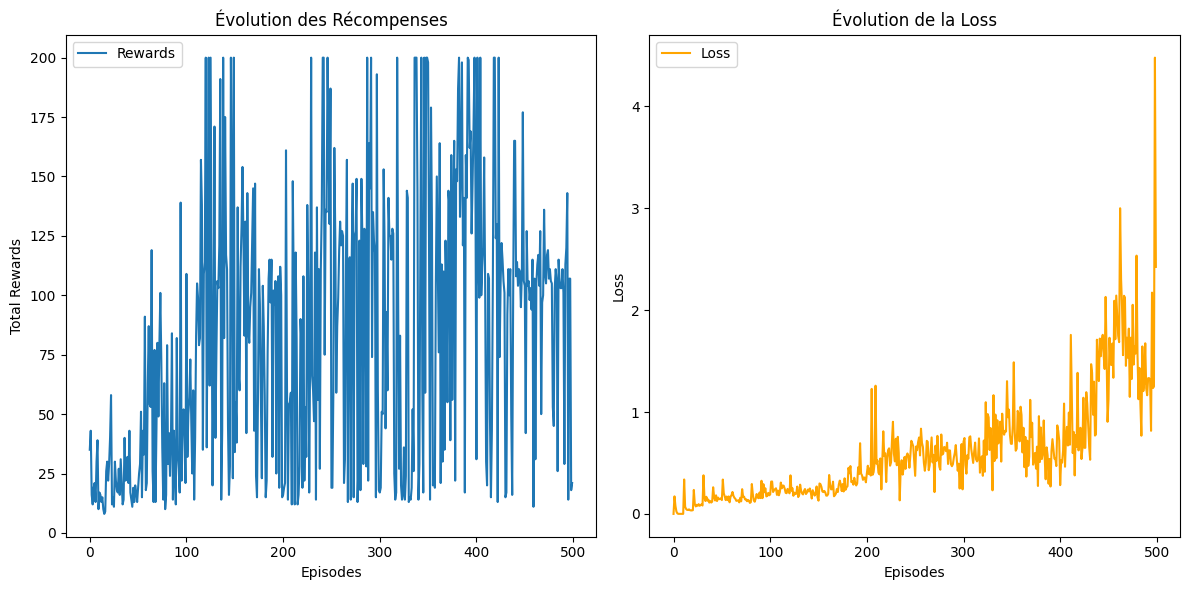

In [13]:
# Visualisation des résultats
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(rewards, label='Rewards')
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.title('Évolution des Récompenses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(losses, label='Loss', color='orange')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.title('Évolution de la Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Visualisation de l'agent

In [14]:
# Visualisation
def render_frame(env):
    frame = env.render()  
    plt.figure(figsize=(6, 4))      # Ajuster la taille de la figure
    plt.imshow(frame)               # Afficher l'image
    plt.axis('off')  
    display(plt.gcf())              # Afficher dans le notebook
    clear_output(wait=True)  
    plt.close()                     # Fermer la figure pour éviter des warnings

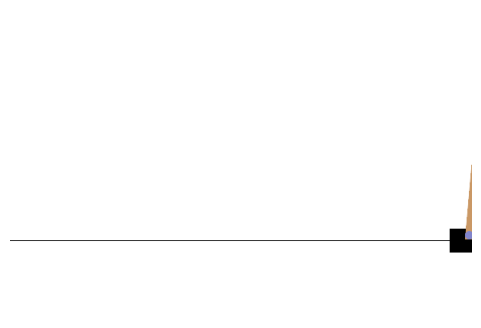

In [15]:
# Visualisation d'un agent entraîné
def render_trained_agent(env, policy_net, episodes=1, max_steps=200):
    """
    Affiche un agent entraîné jouant dans l'environnement.
    """
    for episode in range(episodes):
        state = env.reset()[0]
        total_reward = 0
        for step in range(max_steps):
            render_frame(env)  # Affiche la frame dans le notebook
            # Choix de l'action avec le policy network
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                action = policy_net(state_tensor).argmax(dim=1).item()
            
            state, reward, done, _, _ = env.step(action)
            total_reward += reward
            
            if done:
                break

# Exécution de l'agent entraîné
env = gym.make('CartPole-v1', render_mode='rgb_array')  # Utiliser 'rgb_array' pour l'affichage
render_trained_agent(env, policy_net, episodes=1, max_steps=200)
env.close()
